# Question 3: Regression [20 Marks]

**[Background Story, OK to skip]** You are just graduated from the Starfleet Academy and got assigned as a research engineer in the Starship Enterprise, working under the chief engineer Montgomery "Scotty" Scott.

Scotty assigned you a job to make a model that predicts the **gravimetric field** of a warp drive based on: (i) the **polarization** of the warp manifold, and (ii) its **energy density**.

You have been given a template notebook, data from latest series of experiments, as well as a helper code, which includes the following files:  

1. `final_part_3.ipynb` : this jupyter notebook
2. `dataset.npz` : dataset
3. `helper.py` : helper file

It is known that the gravimetric field undergoes a phase transition when going from **sublight speed** to **warp speed**. When travelling at sublight speed, the effect of polarization on the gravimetric field quickly grows either negatively or positively as its values approach zero, whereas the energy density gives a somewhat "oscilatory" effect. When travelling at warp speed, their effects on sublight speed are superimposed by a new set of effects. In particular, the energy density and polarization have a "certain degree" of influence on the gravimetric field.

To help understand these concepts better, you plot the data that is given to you.

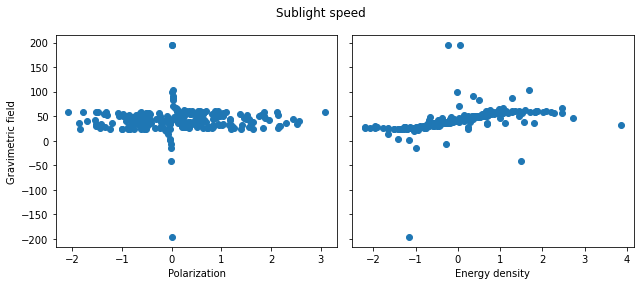

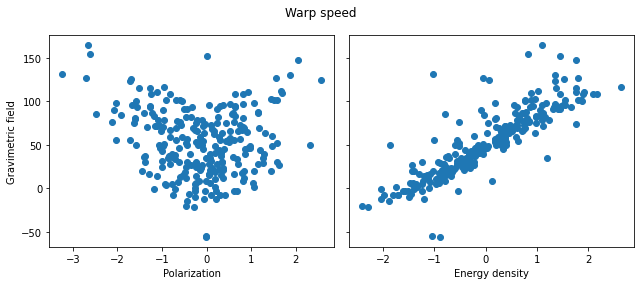

In [1]:
import helper
import numpy as np

X_dict, y = helper.load_data()

X0_label, X1_label, y_label = 'Polarization', 'Energy density', 'Gravimetric field'

helper.plot_scatter_sbs(X_dict['continuous'][X_dict['categorical'] == 'sublight',0][...,np.newaxis], y[X_dict['categorical'] == 'sublight'], 
                      X_dict['continuous'][X_dict['categorical'] == 'sublight',1][...,np.newaxis], y[X_dict['categorical'] == 'sublight'],
                      x1label=X0_label, y1label=y_label, x2label=X1_label, y2label=y_label, title='Sublight speed')

helper.plot_scatter_sbs(X_dict['continuous'][X_dict['categorical'] == 'warp',0][...,np.newaxis], y[X_dict['categorical'] == 'warp'], 
                      X_dict['continuous'][X_dict['categorical'] == 'warp',1][...,np.newaxis], y[X_dict['categorical'] == 'warp'],
                      x1label=X0_label, y1label=y_label, x2label=X1_label, y2label=y_label, title='Warp speed')

## A. Preprocessing and feature engineering [4 Marks]

### A1. Preprocessing [2 Marks]

You noticed that the data consists of a mix of numerical (i.e., energy density, polarization, and gravimetric field) and a categorical variable (warp/sublight speed). Not only that, some of the variables may contains `nan` values.

**[Task]** Preprocess the data by encoding the categorical variable as a binary variable with 1 or 0 value (i.e., 1 for warp speed and 0 for sublight speed). In addition, remove the data with `nan` values.

In [2]:
def preprocessing_function(X_dict, y):
    '''
    This function preprocess the features data and the ground truth targets matrix.
    
    Parameters
    ----------
        - X_dict : features data dictionary (Python dictionary) with entries:
              * 'continuous': continuous features data matrix (numpy float array of shape (m,2)),
              * 'categorical': categorical feature data matrix (numpy string array of shape (m,))
        - y : ground truth targets matrix (numpy array of shape (m,)) 
    Returns
    -------
        - X' : modified features data matrix (numpy float array of shape (m-k,3)),
        - y' : modified ground truth targets matrix (numpy array of shape (m-k,)),
               where k is the number of rows that contain nan values.
               
    Note: m is the number of data points, n is the number of features/attributes
    '''
    Xstring = (X_dict['categorical'] == 'warp').astype(X_dict['continuous'].dtype)[..., np.newaxis]
    X = np.concatenate([X_dict['continuous'], Xstring], axis=1)
    
    not_nan_indices = ~np.isnan(X.mean(1))
    X = X[not_nan_indices]
    y = y[not_nan_indices]
    return X, y

In [3]:
# test execution on sample data

sample_X_dict = {
    'continuous': np.array([
        [1.0, np.nan],
        [2.0, 0.0],
        [3.0, 0.1]
    ]),
    'categorical': np.array([
        'warp',
        'sublight',
        'warp'
    ])
}
sample_y = np.array([1.0, 2.0, 3.0])

sample_X_out, sample_y_out = preprocessing_function(sample_X_dict, sample_y)
print(sample_X_out) # np.array([[2.,  0.,  0.]
                    #           [3.,  0.1, 1.]])
print(sample_y_out) # np.array([2., 3.])

[[2.  0.  0. ]
 [3.  0.1 1. ]]
[2. 3.]


In [4]:
# actual execution on actual data

X_dict, y = helper.load_data()
X_clean, y_clean = preprocessing_function(X_dict, y)

### A2. Feature Engineering [2 Marks]

Based on the description and the plots of the data, you infer that the relationships between the input variables and the output is non-linear. At least, you noticed that there are cases whereby the gravimetric field grows inversely proportional with one of the input variables. In other cases, you also noticed that the gravimetric field may be governed by some polynomial and periodic functions of the input variables.

**[Task]** Engineer a set of features that could potentially help with the prediction. In particular, implement a feature engineering function which adds the following features to the already existing features:

1. Degree two polynomials of $x_0$ and $x_1$, i.e., $x_0^2$ and $x_1^2$.
2. Pairwise multiplication between all features (including features generated in point 1) $x_i x_j, i \ne j$. Note that multiplication is commutative, i.e., $x_i x_j = x_j x_i$ for all $i, j$.
3. Up to 5 features that you think will be helpful in capturing the underlying relationships between the input and output variables as described and plotted (optional).


**[Note]** In Coursemology, the input is preprocessed using our correct implementation of A1. To help you, we have created a test case `report_score(feature_engineering_function)` in Coursemology that will return you a score. A lower score indicates that your set of engineered features are able to better represent the relationship with the "gravimetric field" target variable. Complete parts 1 and 2 first and use this score to help you assess the goodness of your extra features. Do not spend too much time on this question. You can always come back to add extra features later.  You can obtain full credit even if you do not add the extra features in part 3, but doing this well will help you in the last part of this question. 

**[WARNING]** To prevent spamming, we only allow 20 submissions for this part.

In [5]:
def feature_engineering_function(X):
    '''
    This function adds engineered features to the features data matrix
    
    Parameters
    ----------
        - X : features data matrix (numpy array of shape (m,3))
    Returns
    -------
        - X' : modified features data matrix (numpy array of shape (m,3+k)),
               where k is the number of engineered features (12 <= k <= 17)
               
    Note: m is the number of data points
    '''
    # Preserve original X
    X_orig = X
    
    # Polynomial degree 2
    X = np.concatenate([X, X[:,:2] ** 2], axis=1)
    
    # Pairwise
    X_prime = []
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if j >= i: continue
            X_prime.append(X[:,i][:,np.newaxis] * X[:,j][:,np.newaxis])
    X = np.concatenate([X] + X_prime, axis=1)
    
    # 1/x
    X = np.concatenate([X, 1/X_orig[:,:2]], axis=1) # exclude the categorical variables -> 1/0
    
    # sin(x)
    X = np.concatenate([X, np.sin(X_orig[:,:2])], axis=1)
                        
    return X

In [6]:
# test execution on sample data

feature_engineering_function(
    np.array([
        [1., 2., 0.],
        [2., 3., 1.],
    ])
) # np.array containing at least 15 columns, but not more than 20 columns
# you should see the polynomial terms for x_0, and x_1, included, e.g.
# [[1., 2., 0., 1., 4.],
#  [2., 3., 1., 4., 9.]]
# as well as the pairwise multiplication terms, e.g. (x_0 * x_1 will give 2. and 6. for each row respectively)
# [[1., 2., 0., 1., 4., 2., ...],
#  [2., 3., 1., 4., 9., 6., ...]]

# Note: order of features does not matter.

array([[ 1.        ,  2.        ,  0.        ,  1.        ,  4.        ,
         2.        ,  0.        ,  0.        ,  1.        ,  2.        ,
         0.        ,  4.        ,  8.        ,  0.        ,  4.        ,
         1.        ,  0.5       ,  0.84147098,  0.90929743],
       [ 2.        ,  3.        ,  1.        ,  4.        ,  9.        ,
         6.        ,  2.        ,  3.        ,  8.        , 12.        ,
         4.        , 18.        , 27.        ,  9.        , 36.        ,
         0.5       ,  0.33333333,  0.90929743,  0.14112001]])

In [7]:
# actual execution on actual data

X_dict, y = helper.load_data()
X_clean, y_clean = preprocessing_function(X_dict, y)

# Note: Passing the public test case does not guarantee correctness/completeness of your features

## B. Sufficiently advanced learning rate scheduler [3 Marks]

You know that the convergence of gradient descent algorithms depends heavily on the selection of the learning rate (LR). Thus, you are thinking of implementing the idea from CS2109S's tutorial of using a scheduler to reduce the LR as the training progresses. However, implementing such a simple scheduler will not impress Scotty; you need to go beyond simple! So, you came up with a sufficiently advanced LR scheduler that reduces the LR whenever there is no improvement in loss (i.e., loss plateau). The LR scheduler is described below.

The LR scheduler is initialized with an initial learning rate $\alpha = \alpha_0$. At timestep $t$, the LR scheduler will receive the loss of the model $J^{(t)}$ and compare it with the previous loss of the model $J^{(t-1)}$. If the reduction of loss $J^{(t-1)} - J^{(t)}$ is less than or equal to some tolerance threshold $tol$, then we say that there is no improvement of loss at timestep $t$. If there is no such an improvement after $N$ timesteps, then the learning rate $\alpha$ will be updated by multiplying $\alpha$ with some constant multiplier $\gamma \in \mathbb{R}$. If the learning rate $\alpha$ is less than the minimum learning rate $\alpha_{min}$, then we set $\alpha = \alpha_{min}$.

**[Task]** Implement the LR scheduler described above.

In [8]:
class LearningRateScheduler:
    def __init__(self, init_lr, n_iter_no_change, min_lr, lr_multiplier, tol):
        '''
        This function initializes the LR scheduler.

        Parameters
        ----------
            - init_lr : the initial learning rate \alpha_0 (float)
            - n_iter_no_change : the number of steps of no improvement before learning rate is updated (int)
            - min_lr : the minimum learning rate \alpha_{min} (float)
            - lr_multiplier : the constant multiplier \gamma to update the LR (float)
            - tol : the tolerance threshold (float)
        Returns
        -------
            - None
        '''
        self.lr = float(init_lr)
        self.n_iter_no_change = n_iter_no_change
        self.min_lr = float(min_lr)
        self.lr_multiplier = float(lr_multiplier)
        self.tol = float(tol)
        # TODO: you may add your code here if necessary
        self.no_improvement_count = 0
        self.prev_loss = np.inf
        
    def step(self, loss):
        '''
        This function computes and update the learning rate based on the current loss.
        This function is called once at the end of each training step (epoch).

        Parameters
        ----------
            - loss : the loss of the model (float)
        Returns
        -------
            - lr : the current learning rate (float)
        '''
        if self.prev_loss - loss <= self.tol:
            self.no_improvement_count += 1
        else:
            self.no_improvement_count = 0
            
        self.prev_loss = loss
            
        if self.no_improvement_count >= self.n_iter_no_change:
            self.lr = max(self.lr_multiplier * self.lr, self.min_lr)
            self.no_improvement_count = 0
            
        return self.lr

In [9]:
# test execution on sample data

lr_scheduler = LearningRateScheduler(init_lr=1, n_iter_no_change=2, min_lr=0.3, lr_multiplier=0.5, tol=10)
print(*[
    lr_scheduler.step(loss=80), # 1.0
    lr_scheduler.step(loss=50), # 1.0
    lr_scheduler.step(loss=45), # 1.0, no improvement, but needs 2 consecutive
    lr_scheduler.step(loss=40), # 0.5, update with lr_multiplier, because 2 consecutive steps with no improvement
    lr_scheduler.step(loss=10), # 0.5
    lr_scheduler.step(loss=5),  # 0.5, no improvement, but needs 2 consecutive
    lr_scheduler.step(loss=3),  # 0.3, update with lr_multiplier, because 2 consecutive steps with no improvement
    lr_scheduler.step(loss=3),  # 0.3, cannot go below min_lr
], sep="\n")

1.0
1.0
1.0
0.5
0.5
0.5
0.3
0.3


## C. Optimizer with momentum [3 Marks]

**[Background Story, OK to skip]** Due to a malfunction in the Electro-Plasma (EPS) conduit, the engineering section of the starship is currently reserving power and wants you to be as efficient as possible in using its computing resources. 

To do that, you are thinking of accelerating the learning of Stochastic Gradient Descent (SGD) by using the concept of momentum in physics. The idea is to modify the weight update in the gradient descent to consider not only the gradient of the function, but also the previous change of the function. 

### C0. Linear regression model [0 Mark]

We are going to use the optimizer on a linear regression model. The template/class of the model is **implemented and provided** for you below (`LinearModel`). 

**[WARNING]** Do not modify the following implementation to answer C1. However, you may modify the following implementation for other questions if you deem it to be necessary. In such case, please copy paste your custom implementation to Coursemology alongside your answer.

In [10]:
###########################
# DO NOT MODIFY THIS CELL #
###########################

import numpy as np

def add_bias_column(X):
    '''
    This function adds a bias column to the features data matrix

    Parameters
    ----------
        - X : features data matrix (numpy array of shape (m,n))
    Returns
    -------
        - X' : bias-augmented features data matrix (numpy array of shape (m,n+1))
    '''
    return np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

class LinearModel:
    def __init__(self, n_features):
        '''
        This function initializes the weight and the gradient of the model to be
        of size (n_features + 1,) where +1 is for the bias.

        Parameters
        ----------
            - n_features : the number of features of the model
        Returns
        -------
            - self
        '''
        self.W = np.zeros(n_features + 1)
        self.W_grad = np.zeros_like(self.W)
        
    def predict(self, X):
        '''
        This function adds a bias column to the features data matrix
        and predicts the output based on the features data matrix.

        Parameters
        ----------
            - X : features data matrix (numpy array of shape (m,n))
        Returns
        -------
            - y_pred : predictions (numpy array of shape (m,))
        '''
        return np.matmul(add_bias_column(X), self.W)
    
    def grad(self, grad_loss_fn, X, y, y_pred):
        '''
        This function adds a bias column to the features data matrix
        and computes the gradient of the loss function w.r.t. to its weight
        and updates self.W_grad.

        Parameters
        ----------
            - grad_loss_fn : function that computes the gradient
            - X : features data matrix (numpy array of shape (m,n))
            - y : ground truths (numpy array of shape (m,))
            - y_pred : predictions (numpy array of shape (m,))
        Returns
        -------
            - grad : gradient of the loss w.r.t. weight w (numpy array of shape (n+1,))
        '''
        self.W_grad = grad_loss_fn(add_bias_column(X), y, y_pred)
        return self.W_grad

### C1. Implementation [3 Marks]

**[Task]** Implement the momentum optimizer described below.  

Mathematically, the update for the weight $w_i$ is written as follows:

$$
\delta^{(t)}_i = \alpha \cdot \frac{\partial L}{\partial w_i} + \beta \cdot \delta^{(t-1)}_i \\
$$
$$
w_i \leftarrow w_i - \delta^{(t)}_i
$$

where $\alpha$ is the learning rate, $\beta$ is the momentum parameter, and $\delta^{(t)}_i$ is the change at timestep $t$ for the $i$-th component of the weight $w_i$.  

The initial previous change $\delta^{(-1)}_i$ is defined as 0.

In [11]:
class MomentumOptimizer:
    def __init__(self, model, momentum):
        '''
        This function initializes the optimizer.

        Parameters
        ----------
            - model : the model instance used for the linear regression (i.e., LinearModel)
            - momentum : the momentum parameter \beta (float)
        Returns
        -------
            - None
        '''
        self.model = model
        self.momentum = momentum
        # TODO: you may add your code here if necessary
        self.prev_delta = 0
        
    def step(self, learning_rate):
        '''
        This function updates the weight of the model using the formula described in this question.
        This function is called once on each training step. We assume that the gradient of the model
        for the current training step has been computed and stored in `self.model.W_grad`.
        
        This function should updates the weight of the model `self.model.W`.

        Parameters
        ----------
            - learning_rate: the learning rate \alpha to update the model weight (float)
        Returns
        -------
            - None
        '''
        delta = learning_rate * self.model.W_grad + self.momentum * self.prev_delta
        self.model.W = self.model.W - delta
        self.prev_delta = delta

In [12]:
# example execution on sample data

np.random.seed(2109)
sample_model = LinearModel(3)
sample_initial_W = sample_model.W # [0. 0. 0. 0.]
sample_model.W_grad = np.random.rand(3+1) # [0.61284048 0.93157776 0.97676223 0.41667236]
sample_optim = MomentumOptimizer(sample_model, momentum=0.1)
sample_optim.step(learning_rate=0.1)
# all weights of sample_model should be updated
np.all(sample_initial_W != sample_model.W) # True

# The public test case in Coursemology only checks that 
# all the weights in the sample_model in the above example has been updated,
# but does not guarantee that the weight update in MomentumOptimizer was implemented correctly.

True

## D. Faster gradient descent [5 Marks]

You are told to train the linear regression model using gradient descent. However, you have been given strict limited time budgets when using the compute resources. It is unlikely that you will be able to complete the training process within the allocated time budget if you simply use the standard gradient descent. As such, you seriously consider including your learning-rate scheduler and momentum optimizer into your gradient descent algorithm.

**[WARNING]** Do not waste your time in this question! It is good to move on after you are done with your implementation although it is suboptimal. You may revisit this part and optimize your algorithm later if you still have time.

### D0. Preprocessor class [0 Mark]

You may use the following provided preprocessor class to perform preprocessing of the data during training and testing.

In [13]:
class Preprocessor:
    def fit(self, X, y):
        '''
        This function computes and stores the necessary statistics of 
        the features data matrix to perform preprocessing in `transform` method

        Parameters
        ----------
            - X : features data matrix (numpy array of shape (m,n))
        Returns
        -------
            - None
        '''
        X, y = preprocessing_function(X, y)
        X = feature_engineering_function(X)
    
    def transform(self, X, y):
        '''
        This function preprocess the features data matrix

        Parameters
        ----------
            - X : features data matrix (numpy array of shape (m,n))
        Returns
        -------
            - X' : transformed features data matrix (numpy array of shape (m',n+k))
                   where k is the number of new features and m' the number of data after
                   preprocessing. m' != m if the preprocessing function drops some data.
        '''
        X, y = preprocessing_function(X, y)
        X = feature_engineering_function(X)
        return X, y
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

### D1. Implementation [5 Marks]

The **skeleton** of the gradient descent algorithm as been provided for you in the function `gradient_descent` below.  
In this part, you are required to complete the implementations of `gradient_descent_initialization` and `gradient_descent_epoch_step` for `gradient_descent`.

In [14]:
###########################
# DO NOT MODIFY THIS CELL #
###########################

try: from tqdm.notebook import trange
except: trange = range
import helper
import numpy as np
import random

def gradient_descent(loss_fn, grad_loss_fn, X, y, 
                     model_class, preprocessor_class, 
                     gradient_descent_initialization_fn,
                     gradient_descent_epoch_step_fn,
                     max_epoch=1000):
    '''
    This function executes training of a linear regression model using gradient descent.
    
    Parameters
    ----------
        - loss_fn : function that calculates loss/cost value (function)
        - grad_loss_fn : function that calculates the derivative of the loss/cost value(function)
        - X : features data matrix for training (numpy array of shape (m,n))
        - y : ground truth targets matrix for training (numpy array of shape (m,)) 
        - model_class : the model class used for the linear regression (i.e., LinearModel)
        - preprocessor_class: the preprocessor class for the features data (i.e., Preprocessor)
        - max_epoch : maximum number of epoch before termination of gradient descent (int)
    Returns
    -------
        - model : trained model
        - preprocessor: preprocessor fitted for the features data X
        - losses : the list of loss during training
    '''
    
    # Set random seed
    RANDOM_SEED = 42
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    preprocessor = preprocessor_class()
    X, y = preprocessor.fit_transform(X, y)
    
    model = model_class(X.shape[1])
    
    variables = {}
    
    # This will call your implementation: gradient_descent_initialization
    gradient_descent_initialization_fn(variables, loss_fn, grad_loss_fn, X, y, model, preprocessor, max_epoch)
    
    losses = []
    
    for epoch in trange(max_epoch):
        # This will call your implementation: gradient_descent_epoch_step
        epoch_loss, continue_training = gradient_descent_epoch_step_fn(variables, loss_fn, grad_loss_fn, 
                                                                       X, y, model, preprocessor, max_epoch, epoch)
        losses.append(epoch_loss)
        if not continue_training:
            break
    
    return model, preprocessor, losses

**[Task]** Complete the following gradient descent code by implementing the `gradient_descent_initialization` and `gradient_descent_epoch_step` functions and figure out a way to make it converge well with only a few number of epochs. Make sure that your gradient descent converges to a good solution (loss $\le 1$) within the allocated time budget in Coursemology (15 seconds), otherwise we will award you 0 mark. You should also make sure that the algorithm converges in the least number of epochs. We will compare your algorithm with our reference implementation which converges in <= 60 epochs. We use 60 epochs for our reference.

Marks will be given according to the following scheme:

* 5 marks for 0% overhead (<= 60 epochs).
* 4 marks for <=50% overhead (<= 90 epochs).
* 3 marks for <=100% overhead (<= 120 epochs).
* 2 marks for <=200% overhead (<= 180 epochs).
* 1 mark for >200% overhead (> 180 epochs).
 
**[Notes]** 

* To achieve this, you may use the things that you have implemented in the previous questions. You may also come up with new things if you want to.

* You may store your variables in `variables` dictionary during initialization and use it later during the training step.

* The correct implementation of preprocessing function `preprocessing_function` and feature engineering `feature_engineering_function` in part A, learning rate scheduler `LearningRateScheduler` in part B, and momentum optimizer `MomentumOptimizer` in part C are provided in Coursemology. 

* If you want to use your own implementation, you may copy-paste your functions and **rename** them and put them alongside (before) your `gradient_descent_initialization` and `gradient_descent_epoch_step` codes. Be sure to modify the `Preprocessor` class to use your own custom (renamed) implementation of `preprocessing_function` and `feature_engineering_function`. **Do not rename** the `Preprocessor` and `LinearModel` class.

**[WARNING]** 

* Do not modify the `gradient_descent` function as it will be overridden in Coursemology.
* To prevent spamming, we only allow 20 submissions for this part.
* The convergence and the output of your algorithm may differ in Coursemology due to the following reasons:
  * We use a different set of samples for testing in Coursemology, 
  * Hardware may handle numerical precisions differently

In [15]:
'''
These two functions are executed during the initialization and the training step of the gradient descent 
algorithm, respectively.

Parameters
----------
    - variables : a Python dictionary which can be used to store variables during initialization
                  for use later during the training step.
    - loss_fn : function that calculates loss/cost value (function)
    - grad_loss_fn : function that calculates the derivative of the loss/cost value(function)
    - X : features data matrix for training (numpy array of shape (m,n))
    - y : ground truth targets matrix for training (numpy array of shape (m,)) 
    - model : the model instance used for the linear regression (i.e., LinearModel)
    - preprocessor: the preprocessor instance for the features data (i.e., Preprocessor)
    - max_epoch : maximum number of epoch before termination of gradient descent (int)
'''

def gradient_descent_initialization(variables, loss_fn, grad_loss_fn, X, y, model, preprocessor, max_epoch):
    '''
    This function is executed once before the training loop. This function may be used to initialize
    optimizer or other things which may be used within the gradient descent training loop.
    
    Returns
    -------
        - None
    '''
    variables['lr'] = 0.1
    variables['optimizer'] = MomentumOptimizer(model, momentum=0.1)
    variables['lr_scheduler'] = LearningRateScheduler(init_lr=variables['lr'], n_iter_no_change=5, min_lr=1e-5, lr_multiplier=0.1, tol=0.5)
    
    
def gradient_descent_epoch_step(variables, loss_fn, grad_loss_fn, X, y, model, preprocessor, max_epoch, epoch):
    '''
    This function is executed at each training step (epoch). The computation of loss, gradient, and 
    the optimization of the model (updating of weights) should be performed here.
    
    Parameters (Extra)
    ------------------
        - epoch : the current epoch (int)
    
    Returns
    -------
        - (epoch_loss, continue_training): a tuple which stores the loss for the epoch (float) and a boolean flag
                                           on whether training should continue to be performed or not.
                                           `continue_training=True` means training will be continued.
    '''
    optimizer = variables['optimizer']
    lr_scheduler = variables['lr_scheduler']
    
    epoch_losses = []
    for i in range(len(X)):
        _X = X[i][np.newaxis, ...]
        _y = y[i][np.newaxis, ...]

        y_pred = model.predict(_X)
        loss = loss_fn(_y, y_pred)
        model.grad(grad_loss_fn, _X, _y, y_pred)
        optimizer.step(variables['lr'])
        
        epoch_losses.append(loss)
        
    epoch_loss = np.mean(epoch_losses)
    variables['lr'] = lr_scheduler.step(epoch_loss)
    
    if epoch_loss <= 0.1:
        return epoch_loss, False
    return epoch_loss, True

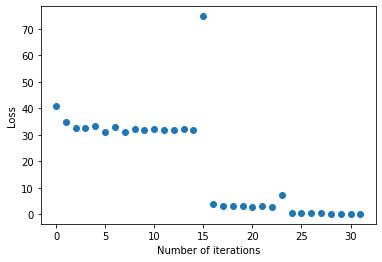

Iterations taken: 32 [0% overhead], final training loss: 0.09623686529791109



0.29661070237094683

In [16]:
# execute gradient descent locally

helper.local_test_gradient_descent(LinearModel, Preprocessor, gradient_descent, 
                                   gradient_descent_initialization, gradient_descent_epoch_step,
                                   fastest_iter=60)

# The test cases on Coursemology will report the number of epochs
# that your gradient descent requires to converge.

### E. Relationships between variables [5 marks]

**[Background Story, OK to skip]** Spock, the head of Enterprise's science department, is intrigued by your machine learning model's accurate prediction. However, he's highly sceptical with any machine learning models due to his believe that everything should be describeable by simple equations. In order to gain his trust, you are thinking of figuring out the mathematical equation of the underlying relationships in the data.

### E1. Explain your approach [3 Marks]

Write a detailed description on how you can uncover the relationships between the input and output variables. Please make sure to include enough details, i.e., explain your understanding about the data, describe the methods that you utilized, justify why it is reasonable, and explain step-by-step on how you could finally arrive with your equation. If you wrote and ran code, please include the code that you used to get your solution as well (if any).

Do not spend too much time on this question if you haven't already finished other parts of this exam. 

**[Hint]** It may be beneficial to consider what you have learned in the class (e.g., modeling, search, optimization, etc) to solve this problem.

Write your answer in Coursemology...

### E2. Write your equation [2 Marks]

Your equation may contain the following:
1. Numbers.
2. Variables: `x_0`, `x_1` and `x_2`, where `x_2 = 1` for warp speed and `x_2 = 0` for sublight speed.
3. Functions: `sin`, `cos`, `tan`, `log`, `exp`, `sqrt`.
4. Operators:`+` (addition), `-` (subtraction),  `*` (multiplication), `/` (division), `^` (power).
6. Brackets: `(`, `)`

Examples of valid equations are given below.
* `( 5 * x_0^2 ) + sin(x_1)`
* `x_0*x_1 + 2/log(x_2)`

**[Note]** You will be judged based on the **correctness** and the **simplicity** of your equation. The correctness is measured by computing the mean absolute error between your equation and the correct equation on a set of samples. The simplicity is measured by the number of arithmetic operations of your equation (given as an overhead compared to the true equation). 

In [17]:
def relationships_equation():
    # TODO: remove the following equation and replace it with your equation
    eq = '21*X_2*X_1 + 12*X_2*X_0^2 + 18*sin(X_1) + 0.8*1/X_0 + 42'
    return eq

In [18]:
import numpy as np
import helper

X = np.random.rand(100, 3)
try:
    helper.evaluate(relationships_equation(), X, zero_nan=True)
    print("Seems ok")
except Exception as e: 
    print('[Parsing Error]')
    print(e)

# The test case in coursemology will check that there is no error when attempting to parse your equation, 
# but does not guarantee that your equation written is the correct one

Seems ok
